# 1. Poisson process with unknown background

In [1]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

## 1. Likelihood

In [2]:
# Poisson pdf
def poisson(n, mu):
    # can the following functions: pow(x,y), np.exp(x), np.math.factorial(n)
    ans = pow(mu,n) * np.exp(-mu) / np.math.factorial(n)
    return ans

# 1. likelihood
def lh(D, Q, s, b, k):
    # protection to stay within physical range
    if (D<=0 or Q<=0 or s+b<0 or b*k<0):
        return 0
    return poisson(D,s+b)*poisson(Q,b*k)

# -2 * log(likelihood)
def lnlh(D, Q, s, b, k):
    l = lh(D, Q, s, b, k)
    if (l<=0):
        return 1e99
    return -2*np.log(l)

# the following "wrappers" are need to call scipy.optimize.fmin
#   which minimises a function w.r.t. its first parameter
# likelihood as a function of b (s is a parameter)
def lh_b(x,*args):
    b = x[0]
    s = args[3]
    D = args[0]
    Q = args[1]
    k = args[2]
    return lh(D,Q,s,b,k)

# -2 * log(likelihood) as a function of b (s is a parameter)
def lnlh_b(x,*args):
    b = x[0]
    s = args[3]
    D = args[0]
    Q = args[1]
    k = args[2]
    return lnlh(D,Q,s,b,k)

## 2. Draw the profile likelihood

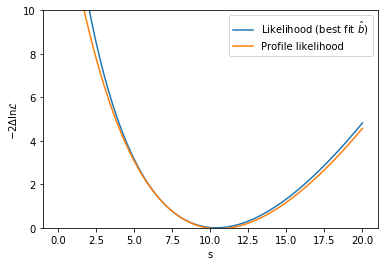

In [3]:
# 2. draw the profile likelihood

# parameters
D = 13
B = 2.6
dB = 0.7

# B = 2.6 +- 0.7
# <Q> = b*k
# k = ? 0.7 = delta(B) = sqrt(Q)/k

# derived quantities
Q = int((B/dB)**2)
k = B/(dB**2)

# arrays for plotting:
# scan of s values
s_vals = np.linspace(0,20,100)
# corresponding log(likelihood) values
lh_vals = []
# corresponding profile log(likelihood) values
proflh_vals = []

# global minimum (ML estimates): \hat{b} and \hat{s}
bhat = B
shat = D-B
# maximum likelihood value
lhmax = lh(D,Q,shat,bhat,k)
# minimum -2*log(likelihood) value
lnlhmin = lnlh(D,Q,shat,bhat,k)

# fill the arrays
for s in s_vals:
    # find the MLE for b, with s fixed to a given value.
    # you can use this minimiser: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
    bhathat = bhathat = optimize.fmin(lnlh_b,bhat,args=(D,Q,k,s),disp=False)
    # fmin returns a bunch of stuff. We are only interested in the value of the parameter which minimises the function.
    bhathat = bhathat[0]
    
    # fill the likelihood value (with b set to the MLE bhat)
    lh_vals.append(lnlh(D,Q,s,bhat,k)-lnlhmin)
    
    # fill the profile likelihood value
    proflh_vals.append(lnlh(D,Q,s,bhathat,k)-lnlhmin)

# plotting
fix, ax = plt.subplots()
ax.plot(s_vals, lh_vals, label='Likelihood (best fit $\hat{b}$)')
ax.plot(s_vals, proflh_vals, label='Profile likelihood')
ax.set_xlabel('s')
ax.set_ylabel('$-2 \Delta \ln \mathcal{L}$')
ax.set_ybound(0,10)
ax.legend()
plt.show()

### Comments on the results:
* The profile likelihood is "wider" than the likelihood with the nuisance set to its best fit value.
* Both have the same minimum, since $\hat{\hat{b}} (\hat{s}) = \hat{b}$ (global minimum for $b$)

## 3. Marginalisation

In [ ]:
# 3. marginalisation

# define priors
def prior_flat_positive(x):
    # a flat prior, restricted to x>0
    ... #TODO

def prior_flat(x):
    # a flat prior defined for both positive and negative values
    ... #TODO

def prior_Jeffreys(s,b):
    # Jeffreys prior for the Poisson mean, in the presence of background b
    ... #TODO

# define posteriors using Bayes' theorem (ignoring normalisation) 
def posterior_flatprior(D,Q,s,b,k):
    ... #TODO

def posterior_Jeffreys(D,Q,s,b,k):
    ... #TODO

def posterior_Jeffreys_b(D,Q,s,b,k):
    ... #TODO

# MCMC: Metropolis-Hastings algorithm
# inputs: 
# - fun: function
# - n: number of iterations
# - D, Q, k: inputs of the problem
# - s0, b0: starting point
# output:
# - (vs,bs) where vs and bs are arrays containing all the successive values for s and b
def mcmc(fun, n, D,Q,s0,b0,k):
    vs = [s0,]
    vb = [b0,]

    # some naive guess of what the variance of s and b could roughly be
    sigmas = max(1,2.*np.sqrt(s0))
    sigmab = max(1,2.*np.sqrt(b0))

    for i in range(0,n):     
        # 1. generate a value \vec{\theta} (= (s,b) in our case) using the proposal density q(theta, theta_0)
        # (we can take q as a Gaussian with mean (s0,b0) and std. dev. (sigmas, sigmab))
        # using https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
        ... #TODO
        
        # 2. Form the Hastings test ratio
        alpha = ...
        
        # 3. Generate u uniformly in [0,1]
        # using https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html
        u = ...
        
        # 4. If u <= alpha, theta1 = theta; otherwise, theta_1 = theta_0
        
        if (i>2000): # burn-in: ignore the first iterations
            vs.append(s1)
            vb.append(b1)
        
        # 5. Set theta_0 = theta_1 and go back to step 1
        s0 = s1
        b0 = b1

    return (vs,vb)


In [ ]:
# number of iterations for MCMC. 100000 takes a few seconds on an i7
niter_mcmc = 100000

In [ ]:
# 3.a flat prior
vals_flat = mcmc(posterior_flatprior, niter_mcmc, D, Q, shat, bhat, k)

# plotting
fig, ax = plt.subplots()
ax.plot(vals_flat[0], vals_flat[1])
ax.set_xlabel('s')
ax.set_ylabel('b')
plt.show()

In [ ]:
# 3.b Jeffreys prior (b=0)
vals_Jeffreys = mcmc(posterior_Jeffreys, niter_mcmc, D, Q, shat, bhat, k)

# plotting
fig, ax = plt.subplots()
ax.plot(vals_Jeffreys[0], vals_Jeffreys[1])
ax.set_xlabel('s')
ax.set_ylabel('b')
plt.show()

In [ ]:
# 3.c Jeffreys prior (b=bhat)
vals_Jeffreys_b = mcmc(posterior_Jeffreys_b, niter_mcmc, D, Q, shat, bhat, k)

# plotting
fig, ax = plt.subplots()
ax.plot(vals_Jeffreys_b[0], vals_Jeffreys_b[1])
ax.set_xlabel('s')
ax.set_ylabel('b')
plt.show()

In [ ]:
# compare the marginalised posteriors
bins = np.linspace(0,30,60)

#plotting
fix, ax = plt.subplots()
ax.hist(vals_flat[0], bins, 
        density=True, label='Flat prior', histtype='step')
ax.hist(vals_Jeffreys[0], bins,
        density=True, label='Jeffreys prior ($b=0$)', histtype='step')
ax.hist(vals_Jeffreys_b[0], bins, 
        density=True, label='Jeffreys prior ($b=\hat{b}$)', histtype='step')
ax.set_xlabel('s')
ax.legend()
plt.show()

# print
print("For s:")
print("Flat prior: mean = %.2f, median = %.2f, std. dev. = %.2f" % 
      (np.mean(vals_flat[0]), np.median(vals_flat[0]), np.std(vals_flat[0])))
print("Jeffreys prior (b=0): mean = %.2f, median = %.2f, std. dev. = %.2f" % 
      (np.mean(vals_Jeffreys[0]), np.median(vals_Jeffreys[0]), np.std(vals_Jeffreys[0])))
print("Jeffreys prior (b=bhat): mean = %.2f, median = %.2f, std. dev. = %.2f" % 
      (np.mean(vals_Jeffreys_b[0]), np.median(vals_Jeffreys_b[0]), np.std(vals_Jeffreys_b[0])))
print("\nFor b:")
print("Flat prior: mean = %.2f, median = %.2f, std. dev. = %.2f" % 
      (np.mean(vals_flat[1]), np.median(vals_flat[1]), np.std(vals_flat[1])))
print("Jeffreys prior (b=0): mean = %.2f, median = %.2f, std. dev. = %.2f" % 
      (np.mean(vals_Jeffreys[1]), np.median(vals_Jeffreys[1]), np.std(vals_Jeffreys[1])))
print("Jeffreys prior (b=bhat): mean = %.2f, median = %.2f, std. dev. = %.2f" % 
      (np.mean(vals_Jeffreys_b[1]), np.median(vals_Jeffreys_b[1]), np.std(vals_Jeffreys_b[1])))
print ("\nMLE: shat = %f, bhat = %f" % (shat, bhat))

### Comments on the results:
TODO Write your comments here